In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng()

## chapter 3
### 1.
suppose that the probabilities that a neuron responds with a firing rate between $r$ and $r + \Delta r$ to two stimuli labeled plus and minus are $p[r|\pm]\Delta r$ where

$p[r|\pm] = \frac{1}{\sqrt{2\pi\sigma}} \exp (-\frac{1}{2}(\frac{r - \langle{r}\rangle{}_\pm}{\sigma_r})^2)$

Assume that the two mean rate parameters $\langle{r}\rangle{}_+$ and $\langle{r}\rangle{}_-$ and the single variance $\sigma_r^2$ are chosen so that these distributions produce negative rates rarely enough that we can integrate over $r$ values over the entire range $-\infty \lt r \lt \infty$. Suppose that you base discrimination of the plus and minus stimuli on whether the evoked firing rate is greater or less than a threshold $z$. Show that the size and power, $\alpha(z)$ and $\beta(z)$ of this test are given by 

$\alpha(z) = \frac{1}{2}\text{erfc}(\frac{z - \langle{r}\rangle{}_-}{\sqrt{2\sigma}_r})$ and $\beta(z) = \frac{1}{2}\text{erfc}(\frac{z - \langle{r}\rangle{}_+}{\sqrt{2\sigma}_r})$

By simulation, determine the fraction of correct discriminations that can be made in the two-alternative forced choice task. show that the fractions of correct answer for different values of $d'$ are equal to the areas under the corresponding ROC curves

In [8]:
from scipy.special import erfc
from scipy.stats import norm

# define functions

def p(r, mean, sigma):
    return 1 / (np.sqrt(2*sigma*np.pi)) * np.exp(-0.5 * ((r - mean) / sigma)**2)

def alpha(z, mean_minus, sigma):
    return 0.5 * erfc((z - mean_minus) / (np.sqrt(2) * sigma))

def beta(z, mean_plus, sigma):
    return 0.5 * erfc((z - mean_plus) / (np.sqrt(2) * sigma))

def d_prime(mean_plus, mean_minus, sigma):
    return (mean_plus - mean_minus) / sigma

def sim_2afc(mean_plus, mean_minus, sigma, n_trials=10000):
    r_plus = np.random.normal(mean_plus, sigma, n_trials)
    r_minus = np.random.normal(mean_minus, sigma, n_trials)
    return np.mean(r_plus > r_minus)

In [17]:
# run simulation
mean_minus = 5
mean_plus = 6
sigma = 2

d_prime_val = d_prime(mean_plus, mean_minus, sigma)
fraction_correct = sim_2afc(mean_plus, mean_minus, sigma)

print(f"d' = {d_prime_val:.4f}")
print(f"Fraction correct (simulated) = {fraction_correct:.4f}")
print(f"Theoretical fraction correct = {0.5 * erfc(-d_prime_val / 2):.4f}")

d' = 0.5000
Fraction correct (simulated) = 0.6361
Theoretical fraction correct = 0.6382


d' = 0.50:
  Fraction correct (simulated) = 0.6295
  Area under ROC curve = -0.6146
d' = 1.00:
  Fraction correct (simulated) = 0.7629
  Area under ROC curve = -0.7353
d' = 1.50:
  Fraction correct (simulated) = 0.8573
  Area under ROC curve = -0.8282
d' = 2.00:
  Fraction correct (simulated) = 0.9229
  Area under ROC curve = -0.8903
d' = 2.50:
  Fraction correct (simulated) = 0.9607
  Area under ROC curve = -0.9262


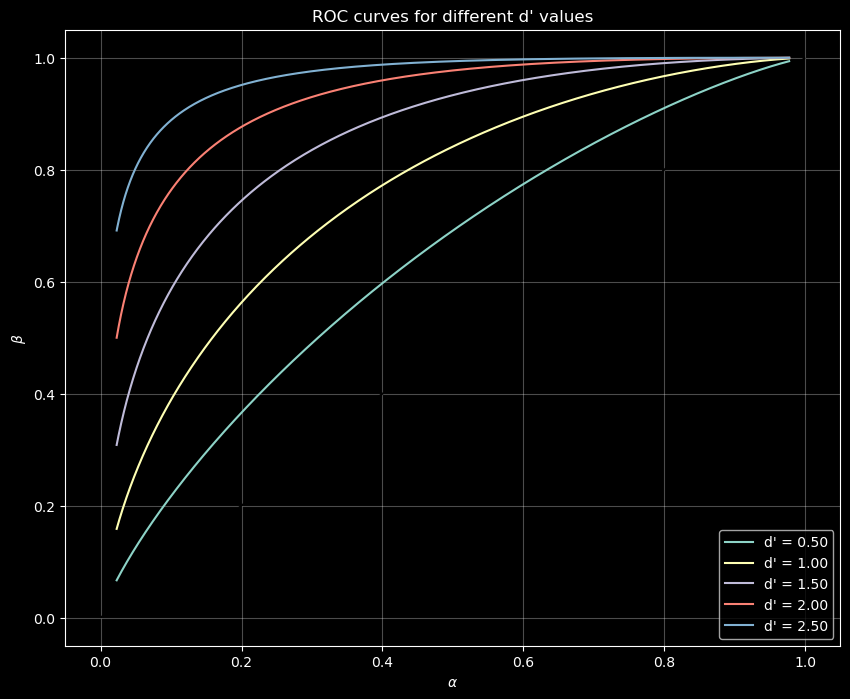

In [26]:
def plot_roc_curves(d_prime_val_list):
    z = np.linspace(-4, 4, 1000)
    plt.figure(figsize=(10, 8))

    for val in d_prime_val_list:
        mean_plus = val * sigma
        mean_minus = 0

        alpha_vals = alpha(z, mean_minus, sigma)
        beta_vals = beta(z, mean_plus, sigma)
        
        plt.plot(alpha_vals, beta_vals, label=f'd\' = {val:.2f}')

        # simulate again and calculate area under ROC
        fraction_correct = sim_2afc(mean_plus, mean_minus, sigma)
        area_under_roc = np.trapz(beta_vals, alpha_vals)

        print(f"d' = {val:.2f}:")
        print(f"  Fraction correct (simulated) = {fraction_correct:.4f}")
        print(f"  Area under ROC curve = {area_under_roc:.4f}")

    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('$\\alpha$')
    plt.ylabel('$\\beta$')
    plt.title('ROC curves for different d\' values')
    plt.legend()
    plt.grid(which='both', alpha=0.3)
    plt.show()

d_prime_values = [0.5, 1, 1.5, 2, 2.5]
plot_roc_curves(d_prime_values)